Global parameter definition

In [1]:
using DifferentialEquations

# Global Parameters
AdoptersResponseTime = 2.0
AdvertisingEffectiveness = 0.0001
AdvertisingEndTime = 6.0
AdvertisingStartTime = 0.0
AIPlatformCoordinationTime = 1.0
DataDepletionRate = 0.1
DataNetworkEffectsStrength = 0.7
DataObjectsCoordinationTime = 1.0
DataObjectsDepletionRate = 0.01
DataSharingRate = 0.1
DataTransferRate = 1.0
ExitRate = 0.01
IndividualDataDepletionRate = 0.01
IndividualDataTransformationTime = 1.0
IndividualLearningEfficiency = 0.05
IndividualLearningTime = 1.0
IndividualQualityDepletionRate = 0.01
InterfaceExpansionFlag = 1.0
ContactRate = 0.7
ProcessCoordinationTime = 2.0
ProcessInnovationFlag = 1.0
ReferenceDataforImprovement = 10.0
ReferenceDataperUser = 100.0
ReferenceDataResourceforAIPlatform = 10000.0
TotalPopulation = 1.0e+06
ValueCreationTime = 2.0

TMAX = 24.0

24.0

Model definition

In [2]:
function system_dynamics!(du, u, param, t)

    DataSharingRate, DataNetworkEffectsStrength = param

     # zidz function moved inside systemdynamics!

     function zidz(a, b)
        if abs(b) < 1e-6
            return 0.0
        else
            return a / b
        end
    end

    # Variables
    Adopters, AIPlatformCapabilities, AIPlatformData, DataObjects, IndividualCustomerData, 
    IndividualQualityofAIPlatform, MachineBasedInnovation, ProcessInnovation, PotentialAdopters = u

    # Intermediate Calculations
    AIPlatformUseOpportunities = AIPlatformData / Adopters
    AIPlatformValue = (1 + (AIPlatformData / ReferenceDataResourceforAIPlatform)^DataNetworkEffectsStrength)
    DataValuePropositionforCustomer = IndividualQualityofAIPlatform * (1 + (IndividualCustomerData / ReferenceDataperUser)^DataNetworkEffectsStrength)
    ValueCreationOpportunitiesforComplements = max((DataValuePropositionforCustomer - MachineBasedInnovation) / ValueCreationTime, 0)

    # Remaining Definitions
    AdvertisingEffects = if t >= AdvertisingStartTime && t < AdvertisingEndTime
        AdvertisingEffectiveness * PotentialAdopters
    else
        0
    end
    WordofMouthEffects = ContactRate * Adopters * PotentialAdopters / TotalPopulation
    NewAdopters = AdvertisingEffects + WordofMouthEffects
    PlatformExit = ExitRate * Adopters / AdoptersResponseTime
    AIPlatformCapabilitiesChange = max((MachineBasedInnovation * Adopters - AIPlatformCapabilities) / AIPlatformCoordinationTime, 0)
    ScopeofData = AIPlatformCapabilities * ProcessInnovation
    ScaleofData = Adopters * IndividualCustomerData
    DataResourceAccumulation = (ScopeofData + ScaleofData) * DataTransferRate
    DataResourceDepletion = AIPlatformData * DataDepletionRate
    DataObjectsAccumulation = max((AIPlatformValue * DataSharingRate - DataObjects) / DataObjectsCoordinationTime, 0)
    DataObjectsDepletion = DataObjects * DataObjectsDepletionRate
    IndividualDataAccumulation = max(((AIPlatformUseOpportunities - IndividualCustomerData) / IndividualDataTransformationTime + ReferenceDataforImprovement * ValueCreationOpportunitiesforComplements), ReferenceDataforImprovement * ValueCreationOpportunitiesforComplements)
    IndividualDataDepletion = IndividualCustomerData * IndividualDataDepletionRate
    MachineLearning = max((IndividualCustomerData * IndividualLearningEfficiency - IndividualQualityofAIPlatform) / IndividualLearningTime, 0)
    ProcessChange = max(ProcessInnovationFlag * (DataObjects - ProcessInnovation) / ProcessCoordinationTime, 0)
    IndividualQualityDepletion = IndividualQualityofAIPlatform * IndividualQualityDepletionRate

    DataBoundaryRate = zidz(ScopeofData,(ScaleofData+ScopeofData))

    # Differential equations
    du[1] = NewAdopters - PlatformExit
    du[2] = AIPlatformCapabilitiesChange
    du[3] = DataResourceAccumulation - DataResourceDepletion
    du[4] = DataObjectsAccumulation - DataObjectsDepletion
    du[5] = IndividualDataAccumulation - IndividualDataDepletion
    du[6] = MachineLearning - IndividualQualityDepletion
    du[7] = ValueCreationOpportunitiesforComplements
    du[8] = ProcessChange
    du[9] = -NewAdopters
end

system_dynamics! (generic function with 1 method)

Initial conditions and time ranges for time integration : 50(points)x 50(points). About 26 Minutes.

In [3]:
# Initial conditions
u0 = [100.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1e+06]

# Time span for the simulation
tspan = (0.0, TMAX)

# Solve the ODE problem for DataSharingRate, DataNetworkEffectsStrength

DataSharingRate_values = range(0.1, stop=1.0, length=50)
DataNetworkEffectsStrength_values = range(0.1, stop=1, length=50)

# zidz function 
function zidz(a, b)
    if abs(b) < 1e-6
        return 0.0
    else
        return a / b
    end
end

results = []

for DataSharingRate in DataSharingRate_values
    for DataNetworkEffectsStrength in DataNetworkEffectsStrength_values
        #
        param = [DataSharingRate, DataNetworkEffectsStrength]

        prob = ODEProblem(system_dynamics!, u0, tspan, param)
        #sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8)
        sol = solve(prob, Tsit5())

        # Extract the time tntegration values at t = TMAX
        Adopters_TMAX = sol.u[end][1]
        AIPlatformCapabilities_TMAX = sol.u[end][2]
        AIPlatformData_TMAX = sol.u[end][3]
        DataObjects_TMAX = sol.u[end][4]
        IndividualCustomerData_TMAX = sol.u[end][5]
        IndividualQualityofAIPlatform_TMAX = sol.u[end][6]
        MachineBasedInnovation_TMAX = sol.u[end][7]
        ProcessInnovation_TMAX = sol.u[end][8]
        PotentialAdopters_TMAX = sol.u[end][9]

        # Extract the values of  DataBoundaryRate at t = TMAX
        ScopeofData_TMAX = sol.u[end][2] * sol.u[end][8] # AIPlatformCapabilities * ProcessInnovation
        ScaleofData_TMAX = sol.u[end][1] * sol.u[end][5] # Adopters * IndividualCustomerData

        DataBoundaryRate_TMAX = zidz(ScopeofData_TMAX, (ScaleofData_TMAX + ScopeofData_TMAX)) 
        
# Print the results
#println("dsr: $DataSharingRate, dne: $DataNetworkEffectsStrength, dbr_TMAX: $DataBoundaryRate_TMAX")

# Store the results
push!(results, (DataSharingRate, DataNetworkEffectsStrength, Adopters_TMAX,
 AIPlatformCapabilities_TMAX, AIPlatformData_TMAX, DataObjects_TMAX, IndividualCustomerData_TMAX, 
 IndividualQualityofAIPlatform_TMAX, MachineBasedInnovation_TMAX, ProcessInnovation_TMAX, PotentialAdopters_TMAX, DataBoundaryRate_TMAX))
    end
end

Output Full Contour Map (Hand coding)

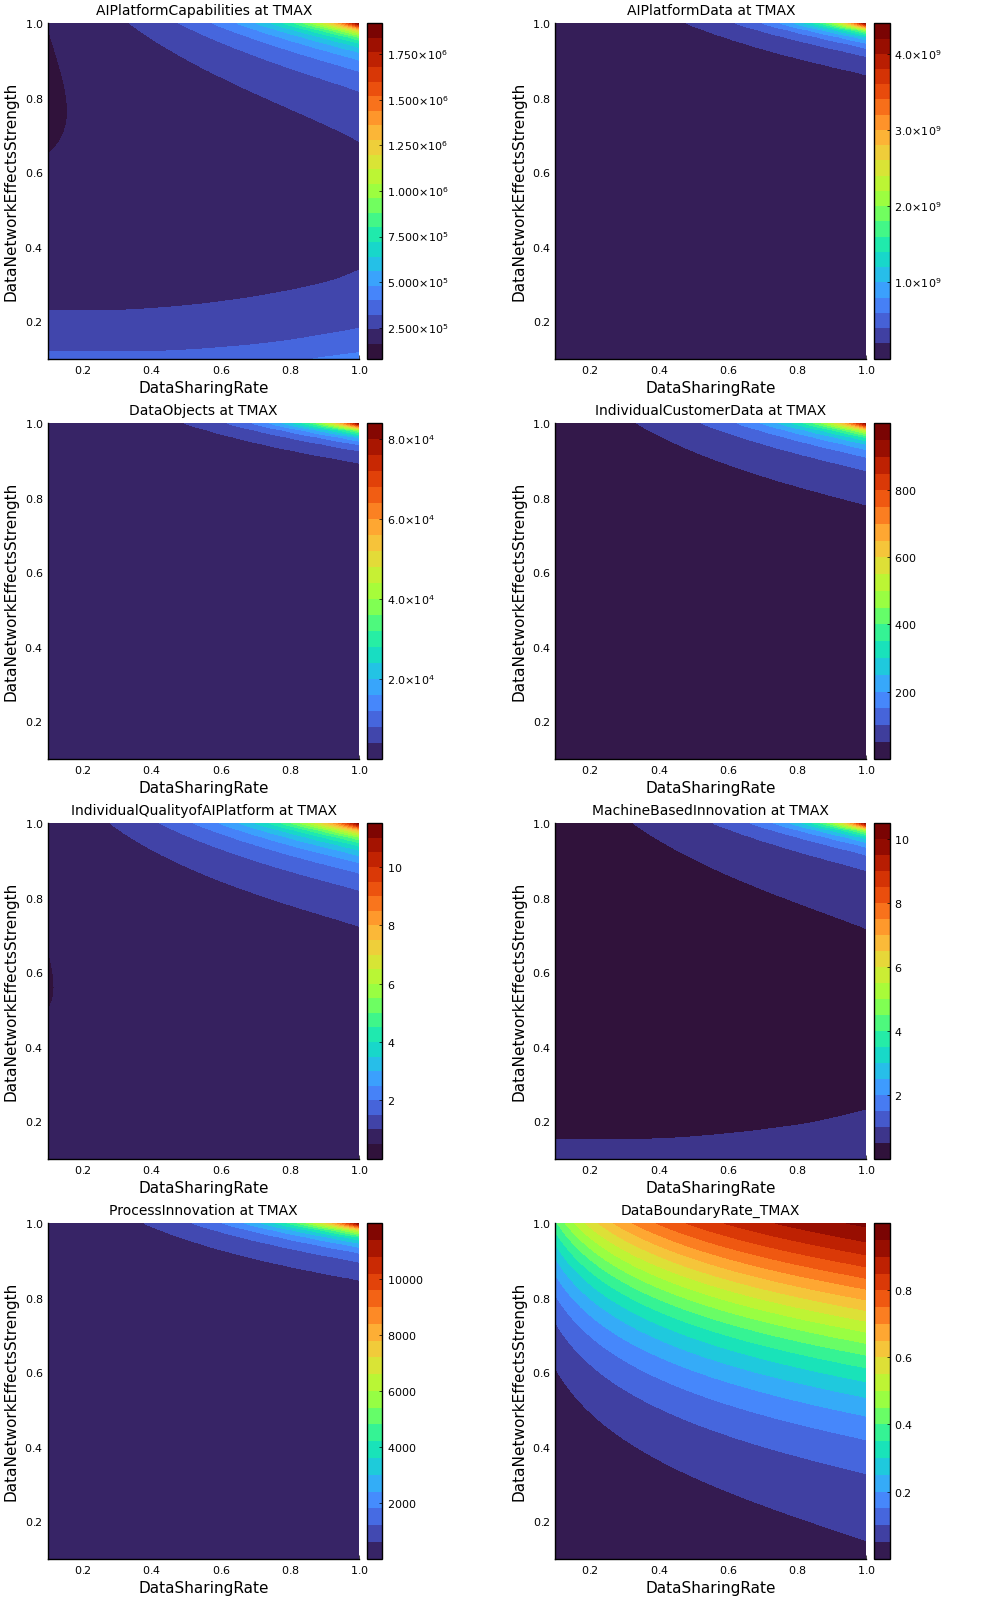

sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'


"c:\\Dropbox\\JuliaDocs\\4_AIplatforms\\fullContourAIPlatforms.pdf"

In [8]:
using CSV, DataFrames
using Plots; pythonplot()
using LaTeXStrings

# Font setting
title_size = 8
legend_size = 6
tick_size = 6
xlabel_size = 8
ylabel_size = 8

plot()

# Define the values for the contour plot
xvals = [r[1] for r in results]
yvals = [r[2] for r in results]
zvals1 = [r[3] for r in results]
zvals2 = [r[4] for r in results]
zvals3 = [r[5] for r in results]
zvals4 = [r[6] for r in results]
zvals5 = [r[7] for r in results]
zvals6 = [r[8] for r in results]
zvals7 = [r[9] for r in results]
zvals8 = [r[10] for r in results]
zvals9 = [r[11] for r in results]
zvals10 = [r[12] for r in results]

# Convert the results to a matrix format suitable for contour plot
xvals_mtrx = reshape(xvals, length(DataSharingRate_values), length(DataNetworkEffectsStrength_values))
yvals_mtrx = reshape(yvals, length(DataSharingRate_values), length(DataNetworkEffectsStrength_values))
zvals1_mtrx = reshape(zvals1, length(DataSharingRate_values), length(DataNetworkEffectsStrength_values))
zvals2_mtrx = reshape(zvals2, length(DataSharingRate_values), length(DataNetworkEffectsStrength_values))
zvals3_mtrx = reshape(zvals3, length(DataSharingRate_values), length(DataNetworkEffectsStrength_values))
zvals4_mtrx = reshape(zvals4, length(DataSharingRate_values), length(DataNetworkEffectsStrength_values))
zvals5_mtrx = reshape(zvals5, length(DataSharingRate_values), length(DataNetworkEffectsStrength_values))
zvals6_mtrx = reshape(zvals6, length(DataSharingRate_values), length(DataNetworkEffectsStrength_values))
zvals7_mtrx = reshape(zvals7, length(DataSharingRate_values), length(DataNetworkEffectsStrength_values))
zvals8_mtrx = reshape(zvals8, length(DataSharingRate_values), length(DataNetworkEffectsStrength_values))
zvals9_mtrx = reshape(zvals9, length(DataSharingRate_values), length(DataNetworkEffectsStrength_values))
zvals10_mtrx = reshape(zvals10, length(DataSharingRate_values), length(DataNetworkEffectsStrength_values))

# Create the contour plots
p1 = contourf(xvals_mtrx, yvals_mtrx, zvals1_mtrx, title="Adopters at TMAX", xlabel="DataSharingRate", ylabel="DataNetworkEffectsStrength", levels=21, color=:turbo, titlefontsize=10)
p2 = contourf(xvals_mtrx, yvals_mtrx, zvals2_mtrx, title="AIPlatformCapabilities at TMAX", xlabel="DataSharingRate", ylabel="DataNetworkEffectsStrength", levels=21, color=:turbo, titlefontsize=10)
p3 = contourf(xvals_mtrx, yvals_mtrx, zvals3_mtrx, title="AIPlatformData at TMAX", xlabel="DataSharingRate", ylabel="DataNetworkEffectsStrength", levels=21, color=:turbo, titlefontsize=10)
p4 = contourf(xvals_mtrx, yvals_mtrx, zvals4_mtrx, title="DataObjects at TMAX", xlabel="DataSharingRate", ylabel="DataNetworkEffectsStrength", levels=21, color=:turbo, titlefontsize=10)
p5 = contourf(xvals_mtrx, yvals_mtrx, zvals5_mtrx, title="IndividualCustomerData at TMAX", xlabel="DataSharingRate", ylabel="DataNetworkEffectsStrength", levels=21, color=:turbo, titlefontsize=10)
p6 = contourf(xvals_mtrx, yvals_mtrx, zvals6_mtrx, title="IndividualQualityofAIPlatform at TMAX", xlabel="DataSharingRate", ylabel="DataNetworkEffectsStrength", levels=21, color=:turbo, titlefontsize=10)
p7 = contourf(xvals_mtrx, yvals_mtrx, zvals7_mtrx, title="MachineBasedInnovation at TMAX", xlabel="DataSharingRate", ylabel="DataNetworkEffectsStrength", levels=21, color=:turbo, titlefontsize=10)
p8 = contourf(xvals_mtrx, yvals_mtrx, zvals8_mtrx, title="ProcessInnovation at TMAX", xlabel="DataSharingRate", ylabel="DataNetworkEffectsStrength", levels=21, color=:turbo, titlefontsize=10)
p10 = contourf(xvals_mtrx, yvals_mtrx, zvals10_mtrx, title="DataBoundaryRate_TMAX", xlabel="DataSharingRate", ylabel="DataNetworkEffectsStrength", levels=21, color=:turbo, titlefontsize=10)

# Display the plot with larger size
p = plot(p2, p3, p4, p5, p6, p7, p8, p10, layout = (4, 2), legend = false, size = (1000, 1600))

display(p)
#
savefig(p, "fullContourAIPlatforms.png")
savefig(p, "fullContourAIPlatforms.pdf")


The values of DataBoundaryRate_TMAX and the corresponding DataSharingRate and DataNetworkEffectsStrength values are recorded in an external file.

In [9]:
using CSV, DataFrames

# Convert results to DataFrame
df = DataFrame(DataSharingRate = [res[1] for res in results], 
               DataNetworkEffectsStrength = [res[2] for res in results], 
               Adopters_TMAX = [res[3] for res in results], 
               AIPlatformCapabilities_TMAX = [res[4] for res in results], 
               AIPlatformData_TMAX = [res[5] for res in results], 
               DataObjects_TMAX = [res[6] for res in results], 
               IndividualCustomerData_TMAX = [res[7] for res in results], 
               IndividualQualityofAIPlatform_TMAX = [res[8] for res in results], 
               MachineBasedInnovation_TMAX = [res[9] for res in results], 
               ProcessInnovation_TMAX= [res[10] for res in results],
               PotentialAdopters_TMAX = [res[11] for res in results],
               DataBoundaryRate_TMAX = [res[12] for res in results])

# Write results to CSV file
CSV.write("results_AIpfm_01.csv", df)

"results_AIpfm_01.csv"

Add an evaluation of the estimated equations by linear regression, interaction regression, exponential regression, and power regression; compare the estimation results using the four models.

In [12]:
using CSV, DataFrames, GLM, Plots, Statistics, StatsBase

# Read the results
df = CSV.read("results_AIpfm_01.csv", DataFrame)

# Log transformation
df.DataBoundaryRate_TMAX_log = log.(df.DataBoundaryRate_TMAX)

# Define a linear model
linear_model = lm(@formula(DataBoundaryRate_TMAX ~ DataSharingRate + DataNetworkEffectsStrength), df)

# Print the coefficients and formula of the linear model
println("Linear Model Equation: DataBoundaryRate_TMAX = ", coef(linear_model)[1], " + ", coef(linear_model)[2], " * DataSharingRate + ", coef(linear_model)[3], " * DataNetworkEffectsStrength")

# Define a model with interaction terms
interaction_model = lm(@formula(DataBoundaryRate_TMAX ~ DataSharingRate*DataNetworkEffectsStrength), df)

# Print the coefficients and formula of the interaction model
println("Interaction Model Equation: DataBoundaryRate_TMAX = ", coef(interaction_model)[1], " + ", coef(interaction_model)[2], " * DataSharingRate + ", coef(interaction_model)[3], " * DataNetworkEffectsStrength + ", coef(interaction_model)[4], " * DataSharingRate * DataNetworkEffectsStrength")

# Define an exponential regression model (requires log transformation)
exp_model = lm(@formula(DataBoundaryRate_TMAX_log ~ DataSharingRate + DataNetworkEffectsStrength), df)

# Print the coefficients and formula of the exponential model
println("Exponential Model Equation: log(DataBoundaryRate_TMAX) = ", coef(exp_model)[1], " + ", coef(exp_model)[2], " * DataSharingRate + ", coef(exp_model)[3], " * DataNetworkEffectsStrength")

# Define a power regression model (requires log transformation)
power_model = lm(@formula(DataBoundaryRate_TMAX_log ~ log(DataSharingRate) + log(DataNetworkEffectsStrength)), df)

# Print the coefficients and formula of the power model
println("Power Model Equation: log(DataBoundaryRate_TMAX) = ", coef(power_model)[1], " + ", coef(power_model)[2], " * log(DataSharingRate) + ", coef(power_model)[3], " * log(DataNetworkEffectsStrength)")

# Predicted values
df.prediction_linear = GLM.predict(linear_model, df)
df.prediction_interaction = GLM.predict(interaction_model, df)
df.prediction_exp = exp.(GLM.predict(exp_model, df))
df.prediction_power = exp.(GLM.predict(power_model, df))

# Compute AIC for each model
aic_linear = aic(linear_model)
aic_interaction = aic(interaction_model)
aic_exp = aic(exp_model)
aic_power = aic(power_model)

# Compute Mean Squared Error
MSE_linear = mean((df.DataBoundaryRate_TMAX .- df.prediction_linear).^2)
MSE_interaction = mean((df.DataBoundaryRate_TMAX .- df.prediction_interaction).^2)
MSE_exp = mean((df.DataBoundaryRate_TMAX .- df.prediction_exp).^2)
MSE_power = mean((df.DataBoundaryRate_TMAX .- df.prediction_power).^2)

# Compute R-squared
TSS = sum((df.DataBoundaryRate_TMAX .- mean(df.DataBoundaryRate_TMAX)).^2)
SSE_linear = sum((df.DataBoundaryRate_TMAX .- df.prediction_linear).^2)
SSE_interaction = sum((df.DataBoundaryRate_TMAX .- df.prediction_interaction).^2)
SSE_exp = sum((df.DataBoundaryRate_TMAX .- df.prediction_exp).^2)
SSE_power = sum((df.DataBoundaryRate_TMAX .- df.prediction_power).^2)
R2_linear = 1 - SSE_linear / TSS
R2_interaction = 1 - SSE_interaction / TSS
R2_exp = 1 - SSE_exp / TSS
R2_power = 1 - SSE_power / TSS

# Display the results in tabular form
println("Linear Model:")
println(coeftable(linear_model))
println("AIC: ", aic_linear)
println("MSE: ", MSE_linear)
println("R-squared: ", R2_linear)
println("---------------")
println("Interaction Model:")
println(coeftable(interaction_model))
println("AIC: ", aic_interaction)
println("MSE: ", MSE_interaction)
println("R-squared: ", R2_interaction)
println("---------------")
println("Exponential Model:")
println(coeftable(exp_model))
println("AIC: ", aic_exp)
println("MSE: ", MSE_exp)
println("R-squared: ", R2_exp)
println("---------------")
println("Power Model:")
println(coeftable(power_model))
println("AIC: ", aic_power)
println("MSE: ", MSE_power)
println("R-squared: ", R2_power)

# Create a DataFrame for model evaluation
model_evaluation = DataFrame(
    Model = ["Linear", "Interaction", "Exponential", "Power"],
    AIC = [aic_linear, aic_interaction, aic_exp, aic_power],
    MSE = [MSE_linear, MSE_interaction, MSE_exp, MSE_power],
    R2 = [R2_linear, R2_interaction, R2_exp, R2_power]
)

# Sort the DataFrame by AIC
sort!(model_evaluation, :AIC)

# Display the DataFrame
println("Model Evaluation:")
println(model_evaluation)

# esave the model_evaluation
CSV.write("estimate_DataBoundaryRate_AIpfm.csv", model_evaluation)

Linear Model Equation: DataBoundaryRate_TMAX = -0.36585912892459777 + 0.29543560139073455 * DataSharingRate + 0.8382162541940914 * DataNetworkEffectsStrength
Interaction Model Equation: DataBoundaryRate_TMAX = -0.13938690143603238 + -0.11633208495211106 * DataSharingRate + 0.4264485678512457 * DataNetworkEffectsStrength + 0.7486685206233549 * DataSharingRate * DataNetworkEffectsStrength
Exponential Model Equation: log(DataBoundaryRate_TMAX) = -5.228963263280088 + 1.6507970983762998 * DataSharingRate + 4.259206416652854 * DataNetworkEffectsStrength
Power Model Equation: log(DataBoundaryRate_TMAX) = -0.07342299729910906 + 0.7489896952894746 * log(DataSharingRate) + 1.7823701155499774 * log(DataNetworkEffectsStrength)
Linear Model:
─────────────────────────────────────────────────────────────────────────────────────────
                                Coef.  Std. Error       t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────────────

"estimate_DataBoundaryRate_AIpfm.csv"

Initial values for nonlinear regression (nonlinear least squares)(1).

In [14]:
using CSV, DataFrames, GLM, Plots, Statistics, StatsBase, LsqFit

# Read the results
df = CSV.read("results_AIpfm_01.csv", DataFrame)

println(size(df.DataSharingRate))
println(size(df.DataNetworkEffectsStrength))
println(size(df.DataBoundaryRate_TMAX))

# Model including interaction term
function model(x, p)
  p[1] .+ p[2].*x[:,1] .+ p[3].*x[:,2] .+ p[4].*x[:,1].^2 .+ p[5].*x[:,2].^2 .+ p[6].*x[:,1].*x[:,2]
end

# Initial guess
p0 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] # Add an initial guess for the new parameter

# Make sure xdata is a 2-dimensional array by transposing it
ydata = df.DataBoundaryRate_TMAX
xdata = hcat(df.DataSharingRate, df.DataNetworkEffectsStrength)

fit = curve_fit(model, xdata, ydata, p0)

# Coefficients of  nonlineear model
coefs = coef(fit)

# Print the coefficients and formula of the nonlinear model
println("Nonlinear Model Equation: DataBoundaryRate_TMAX = ", coefs[1], " + ", coefs[2], " * DataSharingRate + ", coefs[3], " * DataNetworkEffectsStrength + ", coefs[4], " * DataSharingRate^2 + ", coefs[5], " * DataNetworkEffectsStrength^2 + ", coefs[6], " * DataSharingRate * DataNetworkEffectsStrength")

# Predicted values
df.prediction_nonlinear = model(xdata, coefs)

# Compute residual sum of squares for the nonlinear model
SSE_nonlinear = sum((df.DataBoundaryRate_TMAX .- df.prediction_nonlinear).^2)

# Compute AIC for the nonlinear model
n = length(df.DataBoundaryRate_TMAX)
k = length(coefs)
#aic_nonlinear = 2*k - 2*log(SSE_nonlinear/n)
aic_nonlinear = 2*k + 2*log(SSE_nonlinear/n)

# Compute Mean Squared Error for the nonlinear model
MSE_nonlinear = SSE_nonlinear / n

# Compute R-squared for the nonlinear model
TSS = sum((df.DataBoundaryRate_TMAX .- mean(df.DataBoundaryRate_TMAX)).^2)
R2_nonlinear = 1 - SSE_nonlinear / TSS

# Display the results in tabular form for the nonlinear model
println("Nonlinear Model:")
println("Coefficients: ", coefs)
println("AIC: ", aic_nonlinear)
println("MSE: ", MSE_nonlinear)
println("R-squared: ", R2_nonlinear)

# Create a DataFrame for model evaluation
model_evaluation = DataFrame(
    Model = ["Nonlinear"],
    AIC = [aic_nonlinear],
    MSE = [MSE_nonlinear],
    Rsquared = [R2_nonlinear]
)

# Display the DataFrame
println("Model Evaluation:")
println(model_evaluation)

# saving model_evaluation
CSV.write("estimateNL_DataBoundaryRate_AIpfm1.csv", model_evaluation)

(2500,)
(2500,)
(2500,)
Nonlinear Model Equation: DataBoundaryRate_TMAX = 0.1048358156137784 + 0.10631542470562487 * DataSharingRate + -0.9529304403052209 * DataNetworkEffectsStrength + -0.20240682663420234 * DataSharingRate^2 + 1.253980916849615 * DataNetworkEffectsStrength^2 + 0.748668520029973 * DataSharingRate * DataNetworkEffectsStrength
Nonlinear Model:
Coefficients: [0.1048358156137784, 0.10631542470562487, -0.9529304403052209, -0.20240682663420234, 1.253980916849615, 0.748668520029973]
AIC: -3.2659913080697187
MSE: 0.00048420816340262094
R-squared: 0.9925629606194631
Model Evaluation:
1×4 DataFrame
 Row │ Model      AIC       MSE          Rsquared 
     │ String     Float64   Float64      Float64  
─────┼────────────────────────────────────────────
   1 │ Nonlinear  -3.26599  0.000484208  0.992563


"estimateNL_DataBoundaryRate_AIpfm1.csv"

Initial values for nonlinear regression (nonlinear least squares)(2).
# Predicted values
# If the model prediction is negative, set it to 0 #
df.prediction_nonlinear = max.(0.0, model(xdata, coefs))

In [15]:
using CSV, DataFrames, GLM, Plots, Statistics, StatsBase, LsqFit

# Read the results
df = CSV.read("results_AIpfm_01.csv", DataFrame)

println(size(df.DataSharingRate))
println(size(df.DataNetworkEffectsStrength))
println(size(df.DataBoundaryRate_TMAX))

# Model including interaction term
function model(x, p)
  p[1] .+ p[2].*x[:,1] .+ p[3].*x[:,2] .+ p[4].*x[:,1].^2 .+ p[5].*x[:,2].^2 .+ p[6].*x[:,1].*x[:,2]
end

# Initial guess
p0 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] # Add an initial guess for the new parameter

# Make sure xdata is a 2-dimensional array by transposing it
ydata = df.DataBoundaryRate_TMAX
xdata = hcat(df.DataSharingRate, df.DataNetworkEffectsStrength)

fit = curve_fit(model, xdata, ydata, p0)

# Coefficients of  nonlineear model
coefs = coef(fit)

# Print the coefficients and formula of the nonlinear model
println("Nonlinear Model Equation: DataBoundaryRate_TMAX = ", coefs[1], " + ", coefs[2], " * DataSharingRate + ", coefs[3], " * DataNetworkEffectsStrength + ", coefs[4], " * DataSharingRate^2 + ", coefs[5], " * DataNetworkEffectsStrength^2 + ", coefs[6], " * DataSharingRate * DataNetworkEffectsStrength")

# Predicted values
# If the model prediction is negative, set it to 0 #
df.prediction_nonlinear = max.(0.0, model(xdata, coefs))

# Compute residual sum of squares for the nonlinear model
SSE_nonlinear = sum((df.DataBoundaryRate_TMAX .- df.prediction_nonlinear).^2)

# Compute AIC for the nonlinear model
n = length(df.DataBoundaryRate_TMAX)
k = length(coefs)
#aic_nonlinear = 2*k - 2*log(SSE_nonlinear/n)
aic_nonlinear = 2*k + 2*log(SSE_nonlinear/n)

# Compute Mean Squared Error for the nonlinear model
MSE_nonlinear = SSE_nonlinear / n

# Compute R-squared for the nonlinear model
TSS = sum((df.DataBoundaryRate_TMAX .- mean(df.DataBoundaryRate_TMAX)).^2)
R2_nonlinear = 1 - SSE_nonlinear / TSS

# Display the results in tabular form for the nonlinear model
println("Nonlinear Model:")
println("Coefficients: ", coefs)
println("AIC: ", aic_nonlinear)
println("MSE: ", MSE_nonlinear)
println("R-squared: ", R2_nonlinear)

# Create a DataFrame for model evaluation
model_evaluation = DataFrame(
    Model = ["Nonlinear"],
    AIC = [aic_nonlinear],
    MSE = [MSE_nonlinear],
    Rsquared = [R2_nonlinear]
)

# Display the DataFrame
println("Model Evaluation:")
println(model_evaluation)

# saving model_evaluation
CSV.write("estimateNL_DataBoundaryRate_AIpfm2.csv", model_evaluation)


(2500,)
(2500,)
(2500,)
Nonlinear Model Equation: DataBoundaryRate_TMAX = 0.1048358156137784 + 0.10631542470562487 * DataSharingRate + -0.9529304403052209 * DataNetworkEffectsStrength + -0.20240682663420234 * DataSharingRate^2 + 1.253980916849615 * DataNetworkEffectsStrength^2 + 0.748668520029973 * DataSharingRate * DataNetworkEffectsStrength
Nonlinear Model:
Coefficients: [0.1048358156137784, 0.10631542470562487, -0.9529304403052209, -0.20240682663420234, 1.253980916849615, 0.748668520029973]
AIC: -3.447903590102202
MSE: 0.00044211001901952473
R-squared: 0.9932095535133634
Model Evaluation:
1×4 DataFrame
 Row │ Model      AIC      MSE         Rsquared 
     │ String     Float64  Float64     Float64  
─────┼──────────────────────────────────────────
   1 │ Nonlinear  -3.4479  0.00044211   0.99321


"estimateNL_DataBoundaryRate_AIpfm2.csv"

Output contour plots of DataBoundaryRate obtained from simulations and contour plots obtained from general linear regression estimation equations.

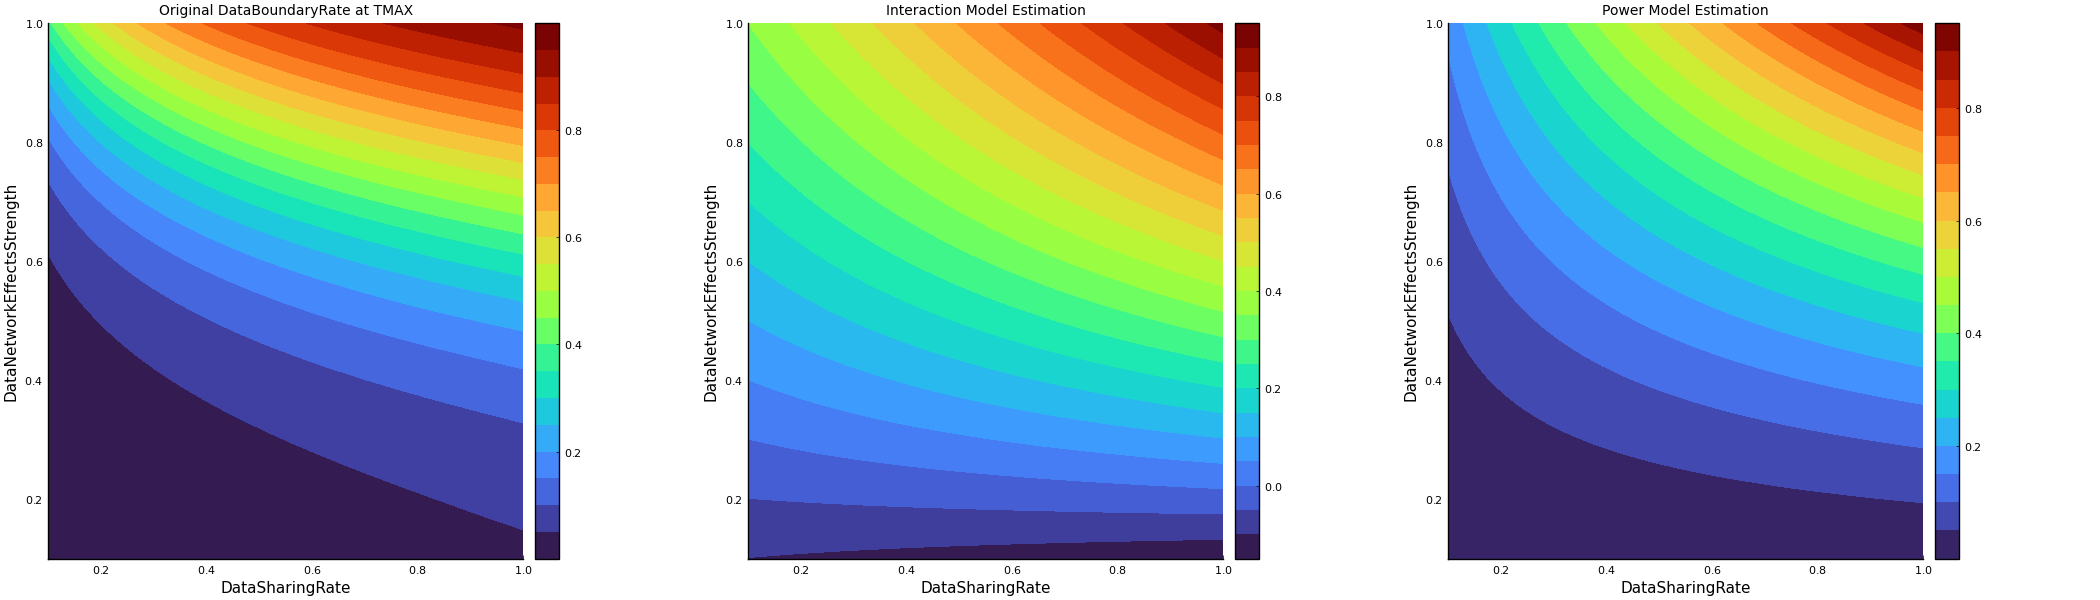

sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'


"c:\\Dropbox\\JuliaDocs\\4_AIplatforms\\comparison_GLM_DataBoundaryRate_AIpfm.pdf"

In [16]:
using CSV, DataFrames
using Plots
using LaTeXStrings

# Function to create a contour plot based on given DataFrame, title and column names
function create_contour_plot(data, title, z_col, pred_col)
    xvals = data[:, :DataSharingRate]
    yvals = data[:, :DataNetworkEffectsStrength]
    zvals = data[:, z_col]

    gridA = sort(unique(xvals))
    gridB = sort(unique(yvals))
    zvals_mtrx = reshape(zvals, length(gridA), length(gridB))

    pivot_df = unstack(data, :DataNetworkEffectsStrength, :DataSharingRate, pred_col)
    predictions_matrix = Matrix(pivot_df[:, 2:end])

    return contourf(gridA, gridB, predictions_matrix, title=title, xlabel="DataSharingRate", ylabel="DataNetworkEffectsStrength", levels=21, color=:turbo, titlefontsize=10)
end

# Read the CSV file into a DataFrame
data = CSV.read("results_AIpfm_01.csv", DataFrame)

# For Interaction Model
data[!, :model_predictions1] = -0.13938690143603333 .+
                                -0.11633208495210925 .* data[!, :DataSharingRate] .+
                                0.4264485678512473 .* data[!, :DataNetworkEffectsStrength] .+
                                0.7486685206233515 .* data[!, :DataSharingRate] .* data[!, :DataNetworkEffectsStrength]

# For Power Model
data[!, :model_predictions2] = exp(-0.07342299729911055) .*
                              (data[!, :DataSharingRate].^0.7489896952894726) .*
                              (data[!, :DataNetworkEffectsStrength] .^ 1.7823701155499774)

# Create individual contour plots
p1 = create_contour_plot(data, "Original DataBoundaryRate at TMAX", :DataBoundaryRate_TMAX, :DataBoundaryRate_TMAX)
p2 = create_contour_plot(data, "Interaction Model Estimation", :DataBoundaryRate_TMAX, :model_predictions1)
p3 = create_contour_plot(data, "Power Model Estimation", :DataBoundaryRate_TMAX, :model_predictions2)

# Combine the plots into one with 3 subplots
p = plot(p1, p2, p3, layout=(1, 3), size=(2100, 600))

# Display the combined plot
display(p)

# Save as image and PDF
savefig(p, "comparison_GLM_DataBoundaryRate_AIpfm.png")
savefig(p, "comparison_GLM_DataBoundaryRate_AIpfm.pdf")

Output contour plots of DataBoundaryRate  obtained from simulations and contour plots obtained from Nonlinear regression models (1) (2) estimation.

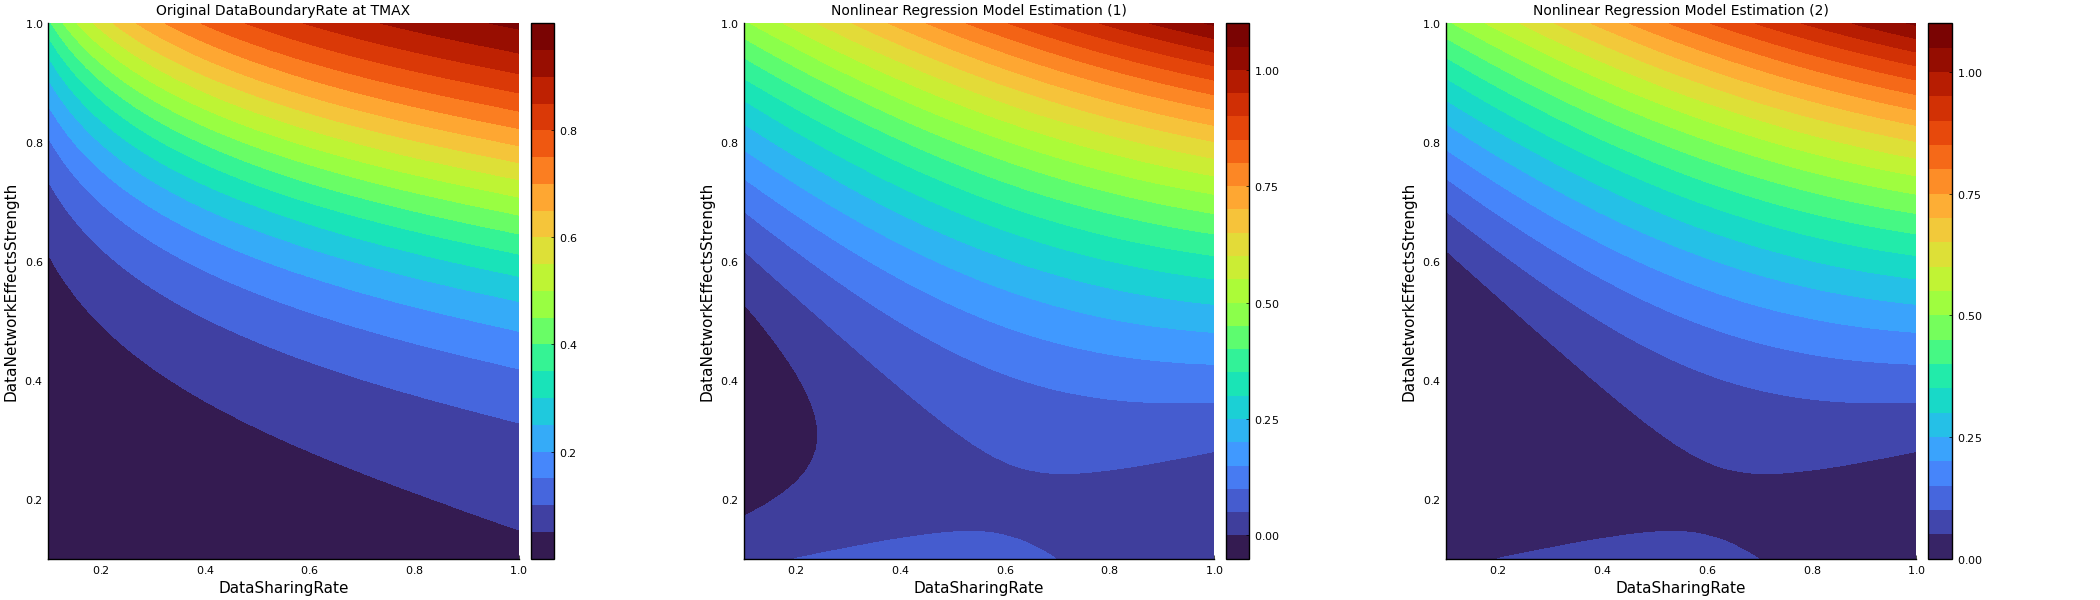

sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'


"c:\\Dropbox\\JuliaDocs\\4_AIplatforms\\comparisonNL_Three_Models_DataBoundaryRate_AIpfm.pdf"

In [17]:
using CSV, DataFrames
using Plots
using LaTeXStrings

# Function to create a contour plot based on given DataFrame, title and column names
function create_contour_plot(data, title, z_col, pred_col)
    xvals = data[:, :DataSharingRate]
    yvals = data[:, :DataNetworkEffectsStrength]
    zvals = data[:, z_col]

    gridA = sort(unique(xvals))
    gridB = sort(unique(yvals))
    zvals_mtrx = reshape(zvals, length(gridA), length(gridB))

    pivot_df = unstack(data, :DataNetworkEffectsStrength, :DataSharingRate, pred_col)
    predictions_matrix = Matrix(pivot_df[:, 2:end])

    return contourf(gridA, gridB, predictions_matrix, title=title, xlabel="DataSharingRate", ylabel="DataNetworkEffectsStrength", levels=21, color=:turbo, titlefontsize=10)
end

# Read the CSV file into a DataFrame
data = CSV.read("results_AIpfm_01.csv", DataFrame)

# Nonlinear Regression Model Estimation (1)
data[!, :model_predictions1] = 0.10483581561270686 .+
                                0.10631542470945503 .* data[!, :DataSharingRate] .+
                                -0.9529304403045394 .* data[!, :DataNetworkEffectsStrength] .+
                                -0.20240682663693343 .* data[!, :DataSharingRate].^2 .+
                                1.253980916849738 .* data[!, :DataNetworkEffectsStrength].^2 .+
                                0.7486685200285323 .* data[!, :DataSharingRate] .* data[!, :DataNetworkEffectsStrength]

# For Nonlinear Regression Model Estimation (2)
data[!, :model_predictions2] = 0.10483581561270686 .+
                                0.10631542470945503 .* data[!, :DataSharingRate] .+
                                -0.9529304403045394 .* data[!, :DataNetworkEffectsStrength] .+
                                -0.20240682663693343 .* data[!, :DataSharingRate].^2 .+
                                1.253980916849738 .* data[!, :DataNetworkEffectsStrength].^2 .+
                                0.7486685200285323 .* data[!, :DataSharingRate] .* data[!, :DataNetworkEffectsStrength]

# If the model prediction2 is negative, set it to 0
data[!, :model_predictions2] = max.(0.0, data[!, :model_predictions2])
                               

# Create individual contour plots
p1 = create_contour_plot(data, "Original DataBoundaryRate at TMAX", :DataBoundaryRate_TMAX, :DataBoundaryRate_TMAX)
p2 = create_contour_plot(data, "Nonlinear Regression Model Estimation (1)", :DataBoundaryRate_TMAX, :model_predictions1)
p3 = create_contour_plot(data, "Nonlinear Regression Model Estimation (2)", :DataBoundaryRate_TMAX, :model_predictions2)

# Combine the plots into one with 3 subplots
p = plot(p1, p2, p3, layout=(1, 3), size=(2100, 600))

# Display the combined plot
display(p)

# Save as image and PDF
savefig(p, "comparisonNL_Three_Models_DataBoundaryRate_AIpfm.png")
savefig(p, "comparisonNL_Three_Models_DataBoundaryRate_AIpfm.pdf")


Output contour plots of DataBoundaryRate  obtained from simulations and contour plots obtained from Power model and Nonlinear regression models (2) estimation.

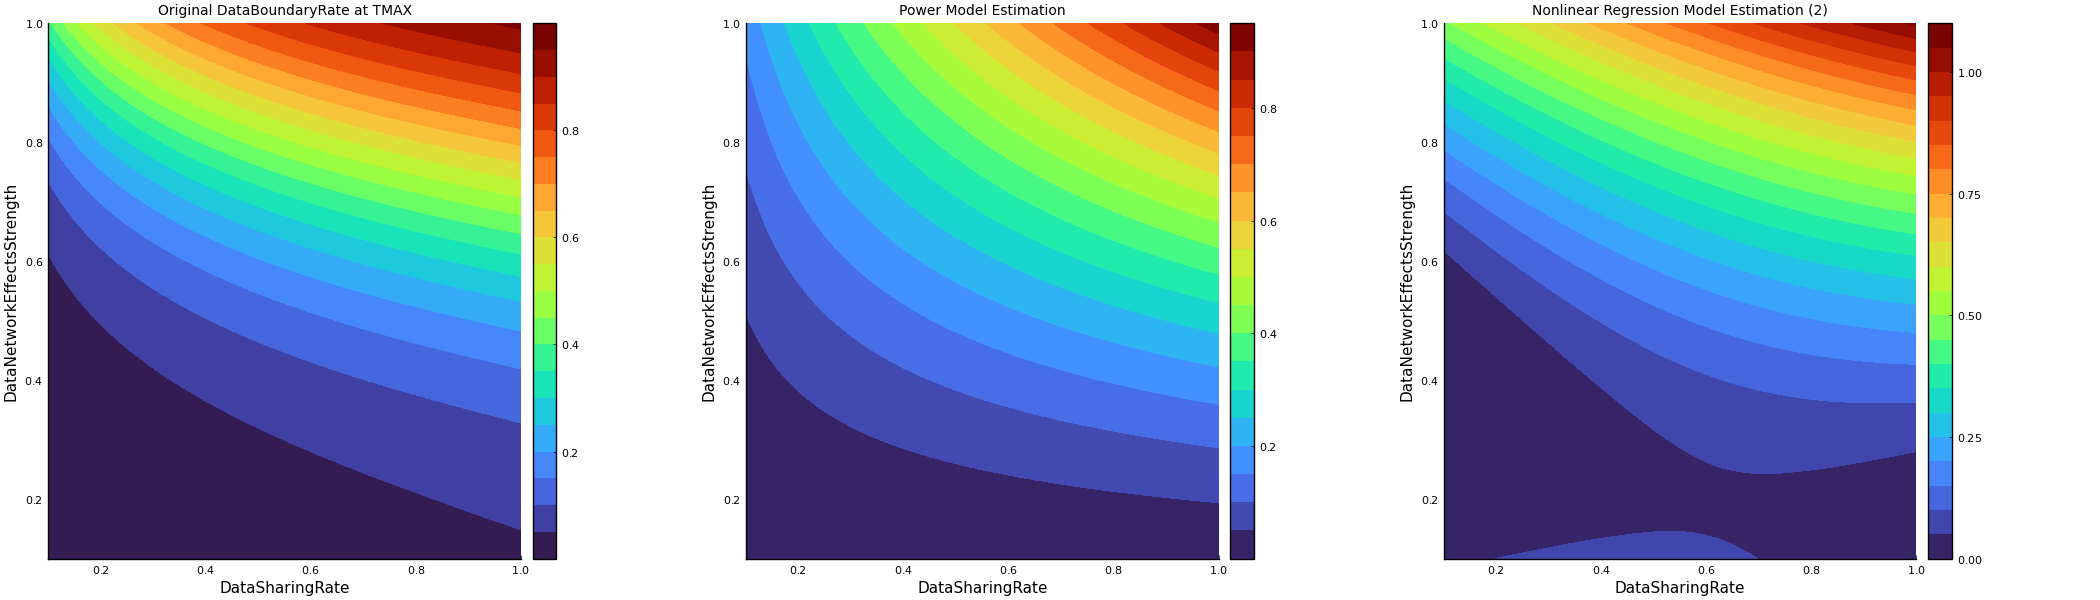

sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'


"c:\\Dropbox\\JuliaDocs\\4_AIplatforms\\comparisonF_Three_Models_DataBoundaryRate_AIpfm.pdf"

In [18]:
using CSV, DataFrames
using Plots
using LaTeXStrings

# Function to create a contour plot based on given DataFrame, title and column names
function create_contour_plot(data, title, z_col, pred_col)
    xvals = data[:, :DataSharingRate]
    yvals = data[:, :DataNetworkEffectsStrength]
    zvals = data[:, z_col]

    gridA = sort(unique(xvals))
    gridB = sort(unique(yvals))
    zvals_mtrx = reshape(zvals, length(gridA), length(gridB))

    pivot_df = unstack(data, :DataNetworkEffectsStrength, :DataSharingRate, pred_col)
    predictions_matrix = Matrix(pivot_df[:, 2:end])

    return contourf(gridA, gridB, predictions_matrix, title=title, xlabel="DataSharingRate", ylabel="DataNetworkEffectsStrength", levels=21, color=:turbo, titlefontsize=10)
end

# Read the CSV file into a DataFrame
data = CSV.read("results_AIpfm_01.csv", DataFrame)

# For Power Model Estimation
data[!, :model_predictions1] = exp(-0.07342299729911055) .*
                              (data[!, :DataSharingRate].^0.7489896952894726) .*
                              (data[!, :DataNetworkEffectsStrength] .^ 1.7823701155499774)

# For Nonlinear Regression Model(2) Estimation
data[!, :model_predictions2] = 0.10483581561270686 .+
                                0.10631542470945503 .* data[!, :DataSharingRate] .+
                                -0.9529304403045394 .* data[!, :DataNetworkEffectsStrength] .+
                                -0.20240682663693343 .* data[!, :DataSharingRate].^2 .+
                                1.253980916849738 .* data[!, :DataNetworkEffectsStrength].^2 .+
                                0.7486685200285323 .* data[!, :DataSharingRate] .* data[!, :DataNetworkEffectsStrength]

# If the model prediction2 is negative, set it to 0
data[!, :model_predictions2] = max.(0.0, data[!, :model_predictions2])
                               
                                

# Create individual contour plots
p1 = create_contour_plot(data, "Original DataBoundaryRate at TMAX", :DataBoundaryRate_TMAX, :DataBoundaryRate_TMAX)
p2 = create_contour_plot(data, "Power Model Estimation", :DataBoundaryRate_TMAX, :model_predictions1)
p3 = create_contour_plot(data, "Nonlinear Regression Model Estimation (2)", :DataBoundaryRate_TMAX, :model_predictions2)

# Combine the plots into one with 3 subplots
p = plot(p1, p2, p3, layout=(1, 3), size=(2100, 600))

# Display the combined plot
display(p)

# Save as image and PDF
savefig(p, "comparisonF_Three_Models_DataBoundaryRate_AIpfm.png")
savefig(p, "comparisonF_Three_Models_DataBoundaryRate_AIpfm.pdf")

Three areas within the DataBoundaryRate contour map

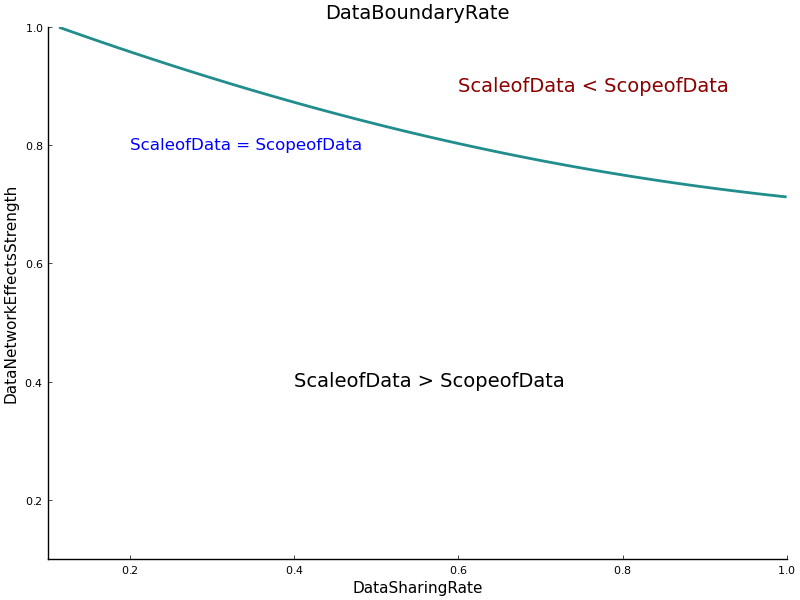

"c:\\Dropbox\\JuliaDocs\\4_AIplatforms\\ThreeAreas_DataBoundaryRate_AIpfm.pdf"

In [19]:
using Plots

# Nonlinear Regression Line Plot
function equation(X, Y)
    return 0.10483581561270686 + 0.10631542470945503 * X + -0.9529304403045394 * Y + -0.20240682663693343 * X^2 + 1.253980916849738 * Y^2 + 0.7486685200285323 * X * Y - 0.5
end

# X and Y range
x_range = 0.1:0.01:1.0
y_range = 0.1:0.01:1.0


# Plot the equation

graph_size = (800, 600)

#p = contour(x_range, y_range, equation, levels=[0], linewidth=2, linecolor=:blue, xlabel="DataSharingRate", ylabel="DataNetworkEffectsStrength", title="DataBoundaryRate", size=graph_size, colorbar=false)
p = contour(x_range, y_range, equation, levels=[0], linewidth=2, linecolor=:blue, 
xlabel="DataSharingRate", ylabel="DataNetworkEffectsStrength", title="DataBoundaryRate", size=graph_size, colorbar=false, grid=false)

# Labelling (x, y, Label)
label_fontsize1 = 12

annotate!(p, 0.4, 0.4, text("ScaleofData > ScopeofData", :black, :left))
#
annotate!(p, 0.2, 0.8, text("ScaleofData = ScopeofData", :blue, :left, label_fontsize1))
#
annotate!(p, 0.6, 0.9, text("ScaleofData < ScopeofData", :darkred, :left))

# Plot graph
display(p)

# export the graph to the file
savefig(p, "ThreeAreas_DataBoundaryRate_AIpfm.png")
#
savefig(p, "ThreeAreas_DataBoundaryRate_AIpfm.pdf")